In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
import pandas as pd

np.random.seed(20)

In [2]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 200
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In [3]:
def kmeans_plot(data, labels):
    fig, ax = plt.subplots()

    for i in range(N):
        x = data[labels == i, 0]
        y = data[labels == i, 1]

        ax.scatter(x, y, s=10, alpha=.8)

In [4]:
def concatData(X, labels):
    converted_labels = np.expand_dims(labels, axis=1)
    data = np.concatenate((X, converted_labels), axis=1) 

    return data


def drawGifClustering(data, step, iternum, centroids):
    df = pd.DataFrame(data, columns=['x', 'y', 'label'])
    df['label'] = df['label'].astype('int')
    df['cen_x'] = df.label.map({0:centroids[0][0], 1:centroids[1][0], 2:centroids[2][0]})
    df['cen_y'] = df.label.map({0:centroids[0][1], 1:centroids[1][1], 2:centroids[2][1]})
    colors = ['#DF2020', '#81DF20', '#000000']
    process = {
        'label': 'assign label',
        'centroid': 'update centroids'
    }
    if iternum == 0:
        process['centroid'] = 'initialize centroids'

    plt.figure(figsize=(9,8))

    #draw points
    for i in df.label.unique():
        points = df[df.label == i][['x', 'y']].values
        color = colors[i]

        #plot all points
        plt.scatter(points[:, 0], points[:, 1], c=color, s=20, alpha=0.4)

        # get convex hull
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

        centroid = df[df.label == i][['cen_x', 'cen_y']].iloc[0]
        plt.scatter(centroid[0], centroid[1], c=colors[i], marker='^', s=100)
        

    plt.title(f'Iter {iternum + 1}: {process[step]}')
    plt.xlim(-1,11)
    plt.ylim(-1,9)

    name = f'{iternum + 1}_{step}'
    plt.savefig(f'gif_image/{name}.png')

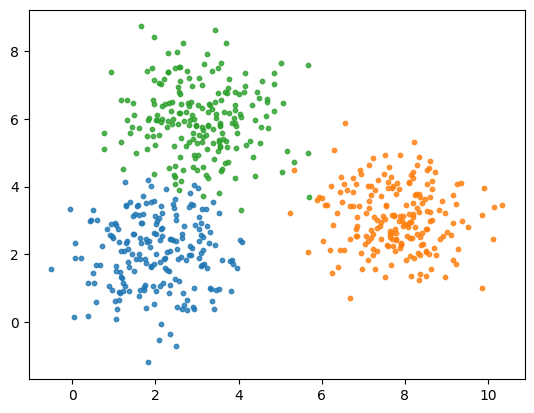

In [5]:
kmeans_plot(X, original_label)

In [6]:
def assign_label(data, centroids):
    D = cdist(data, centroids)
    labels = np.argmin(D, axis=1)

    return labels

def update_centroids(data, labels, centroid_id):
    centroid_points = data[labels == centroid_id, :]
    new_centroid = np.mean(centroid_points, axis=0)

    return new_centroid

In [7]:
def k_means(data, K, max_it_num=10):
    #init centroids
    centroids = data[np.random.choice(data.shape[0], K, replace=False)]
    labels_hist = []
    it_count = 0

    for iternum in range(max_it_num):    
        label = assign_label(data, centroids)
        gif_data = concatData(data, label)
    
        if len(labels_hist) != 0 and (label == labels_hist[-1]).all():
            break

        labels_hist.append(label)

        drawGifClustering(gif_data, 'label', iternum, centroids)

        for centroid_id in range(K):
            centroids[centroid_id] = update_centroids(data, label, centroid_id)

        drawGifClustering(gif_data, 'centroid', iternum, centroids)

        it_count += 1
    
    return (it_count, labels_hist[-1], centroids)

/tmp/ipykernel_17468/1267385111.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,8))


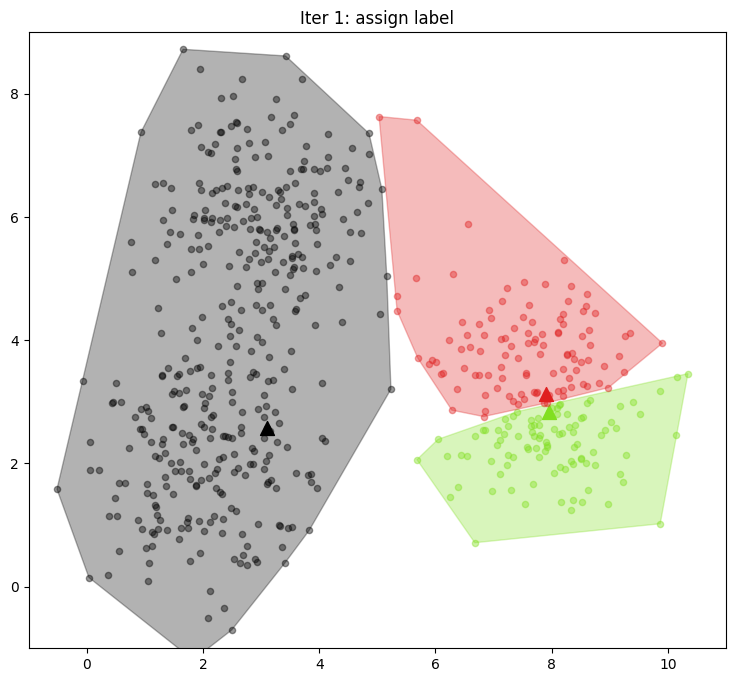

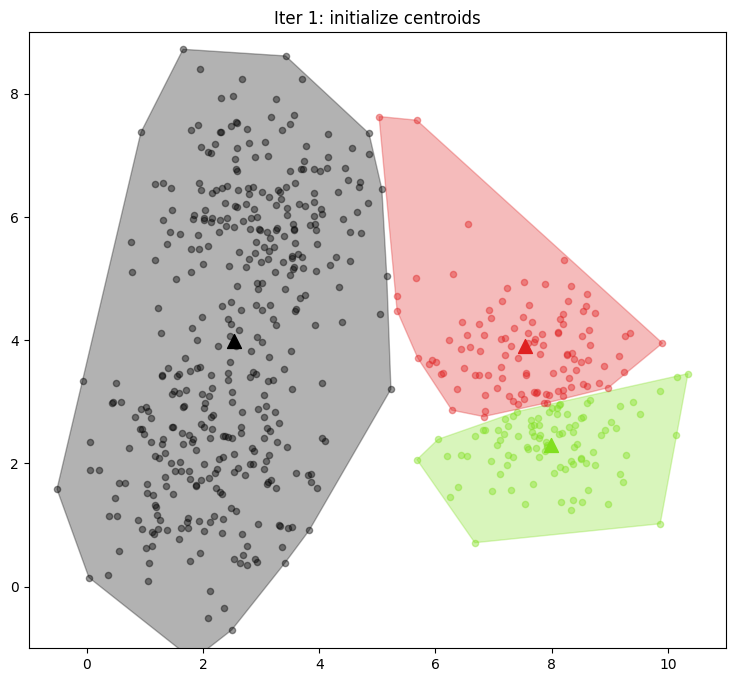

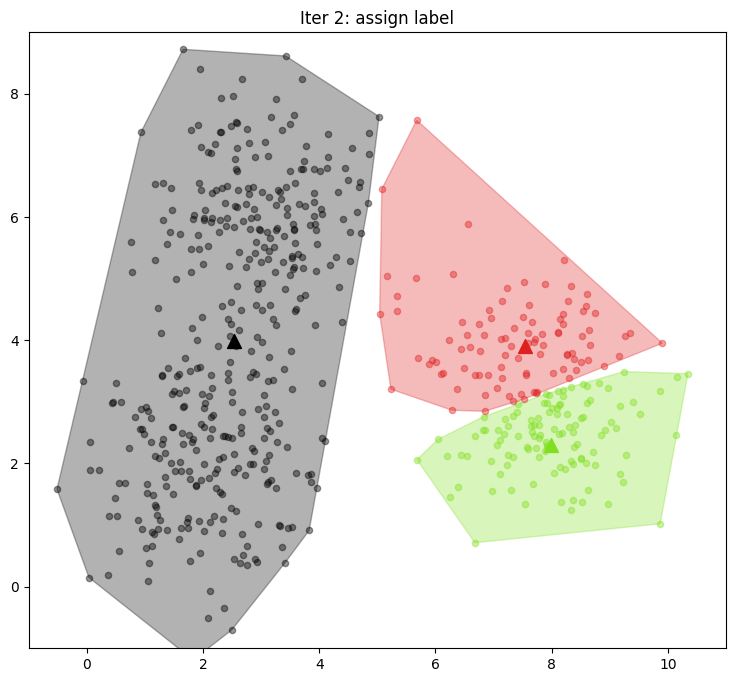

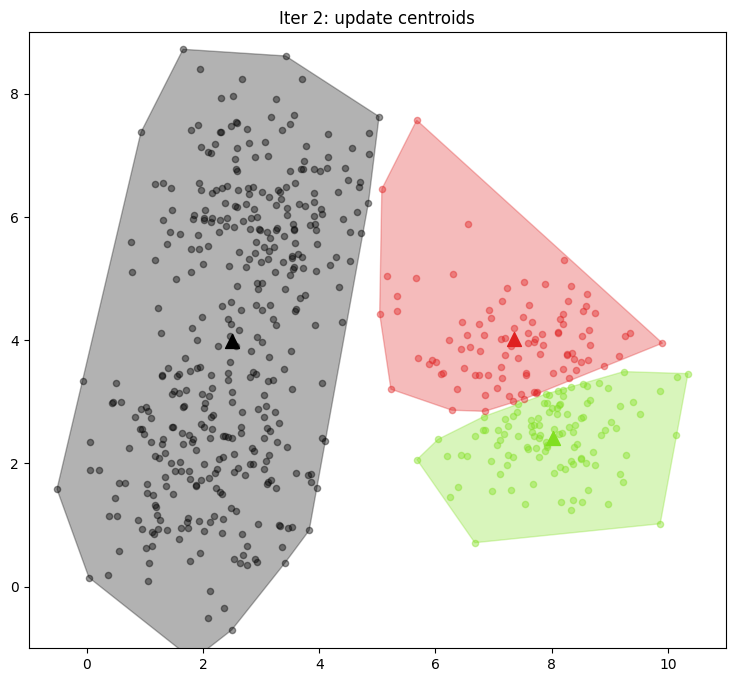

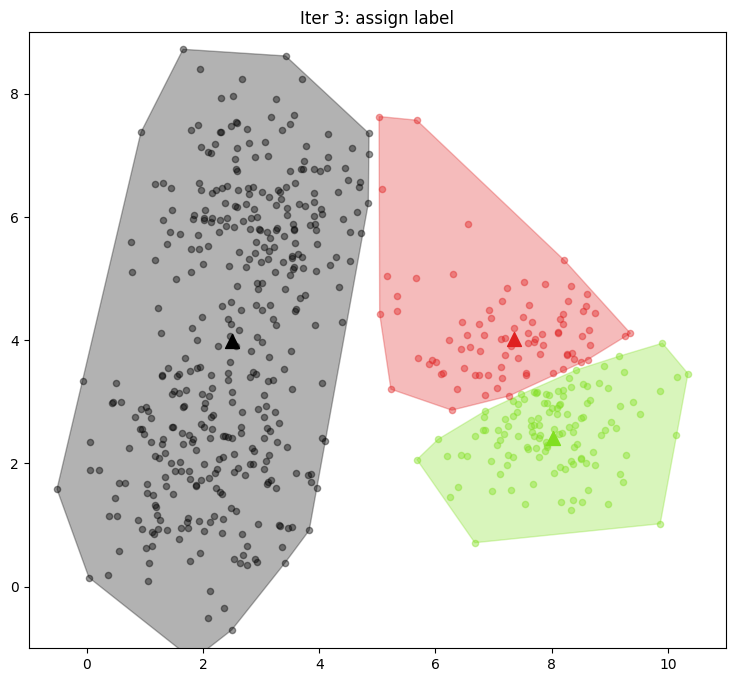

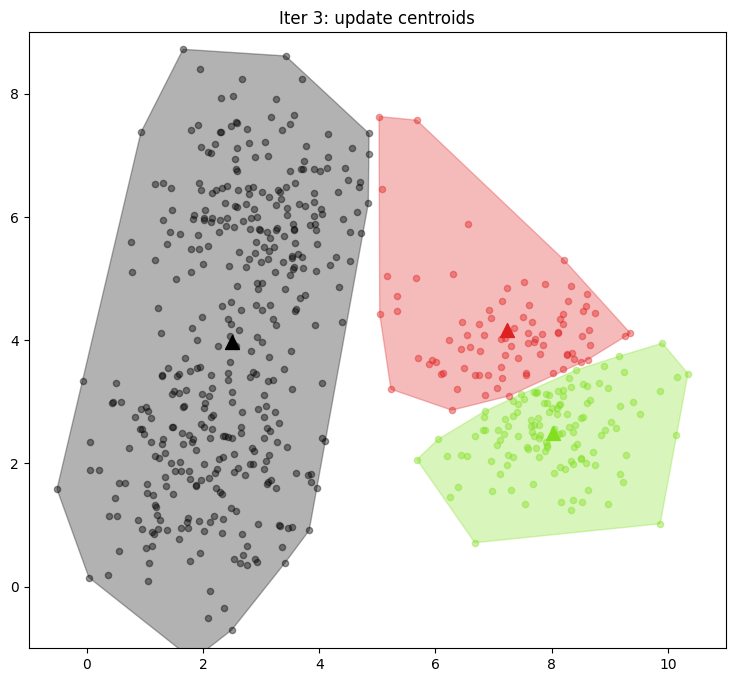

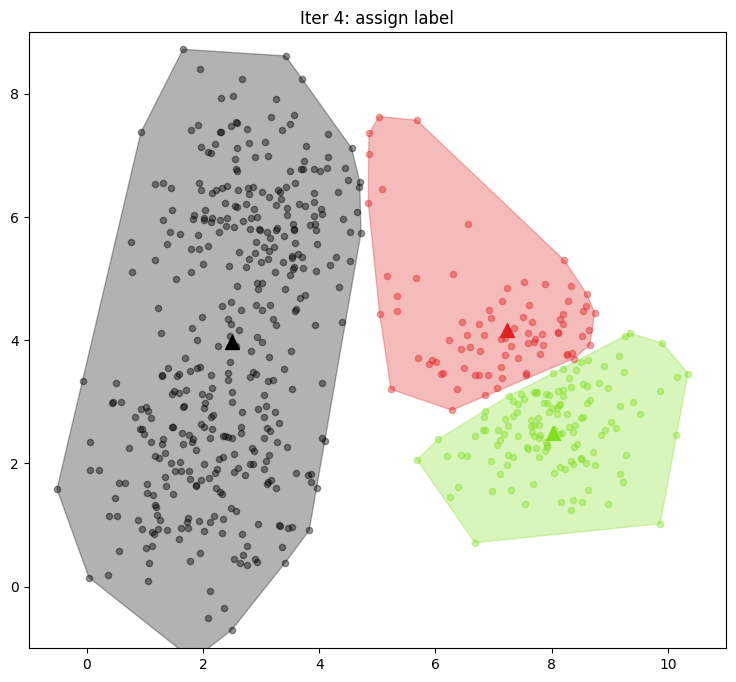

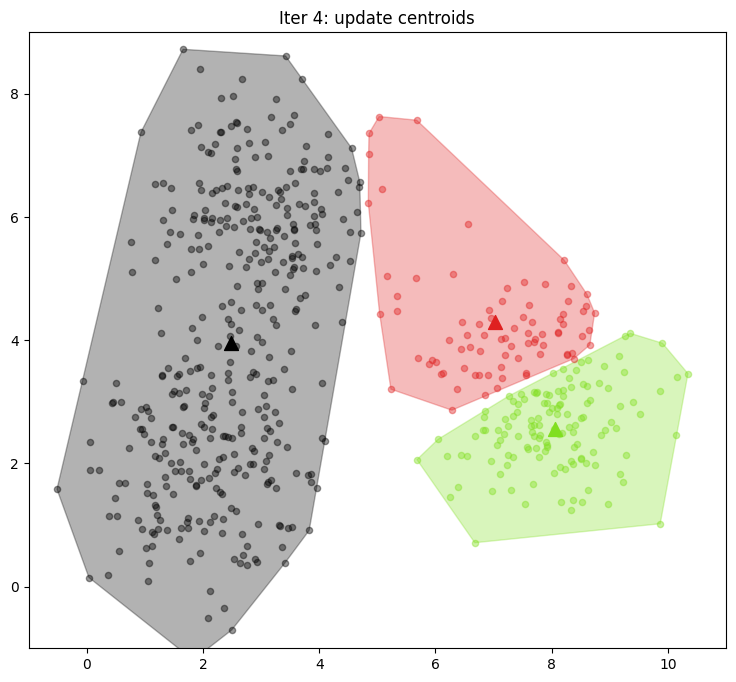

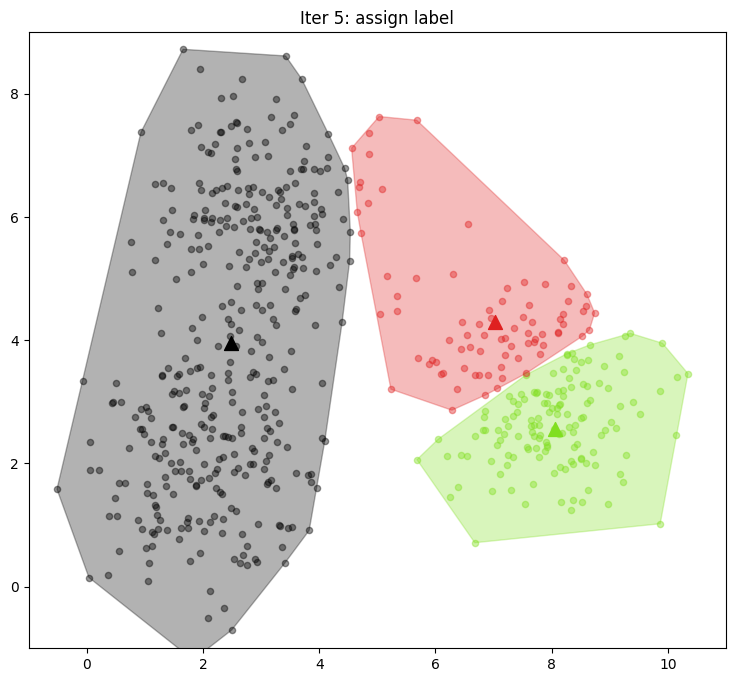

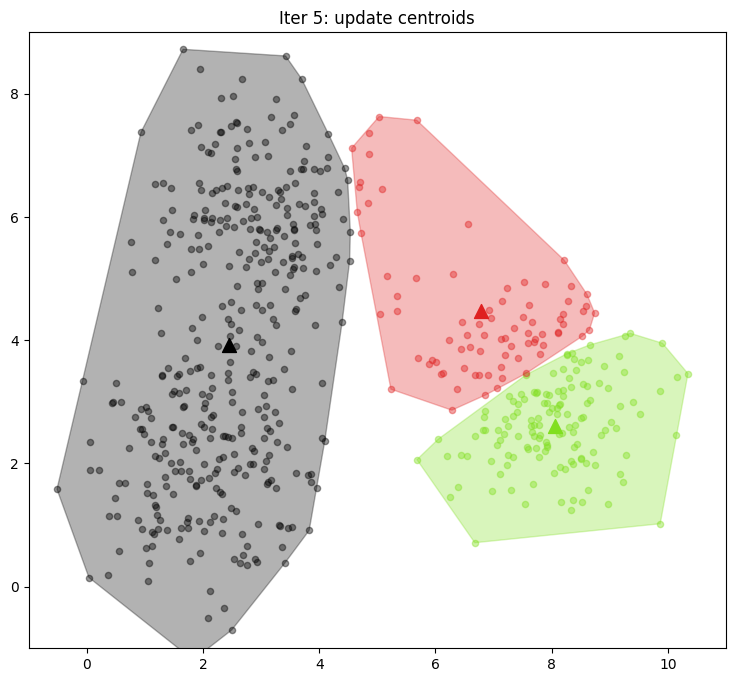

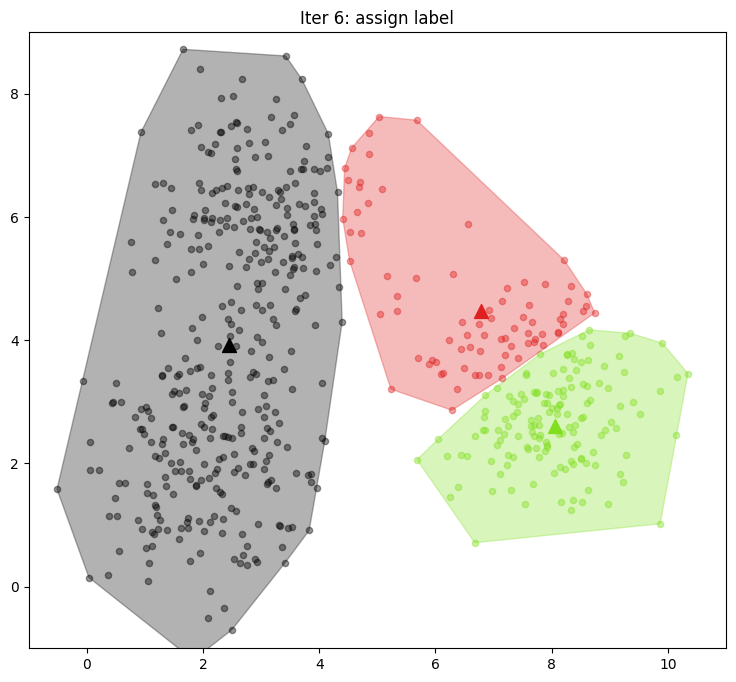

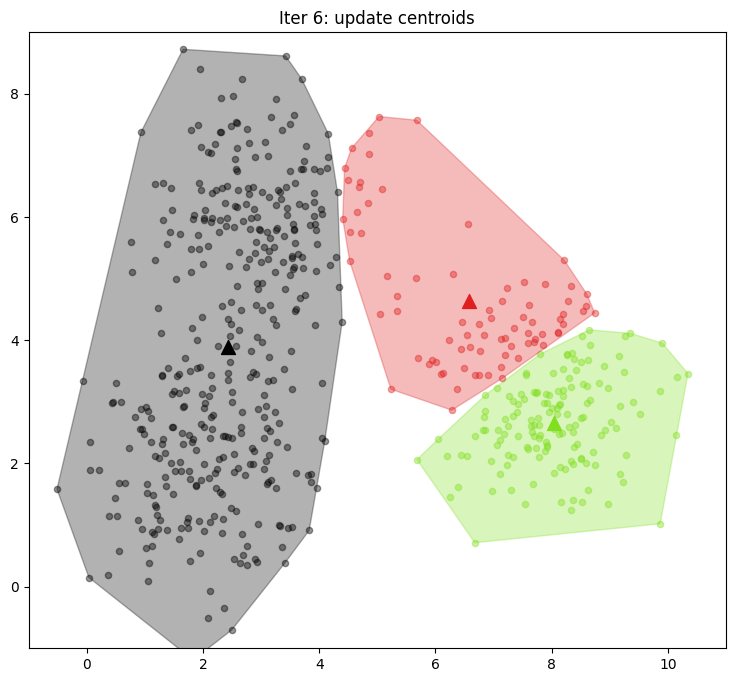

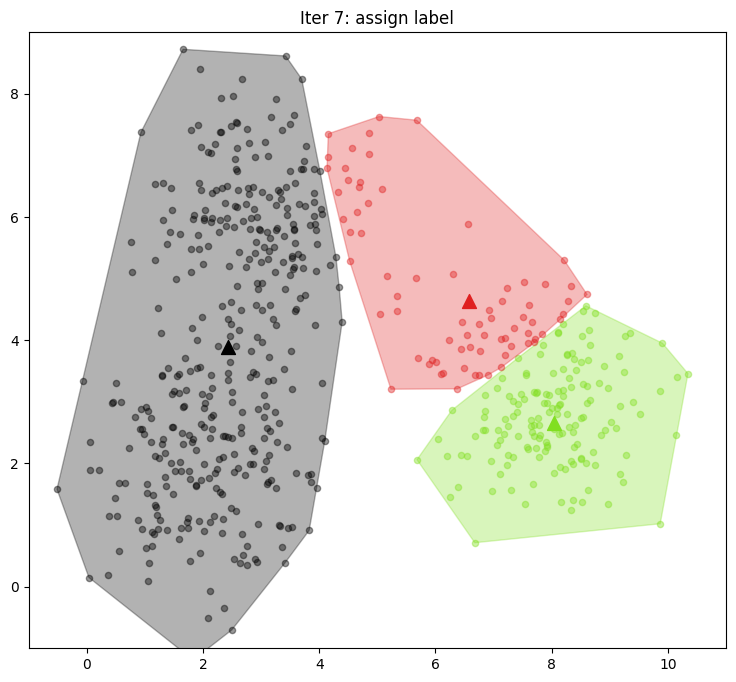

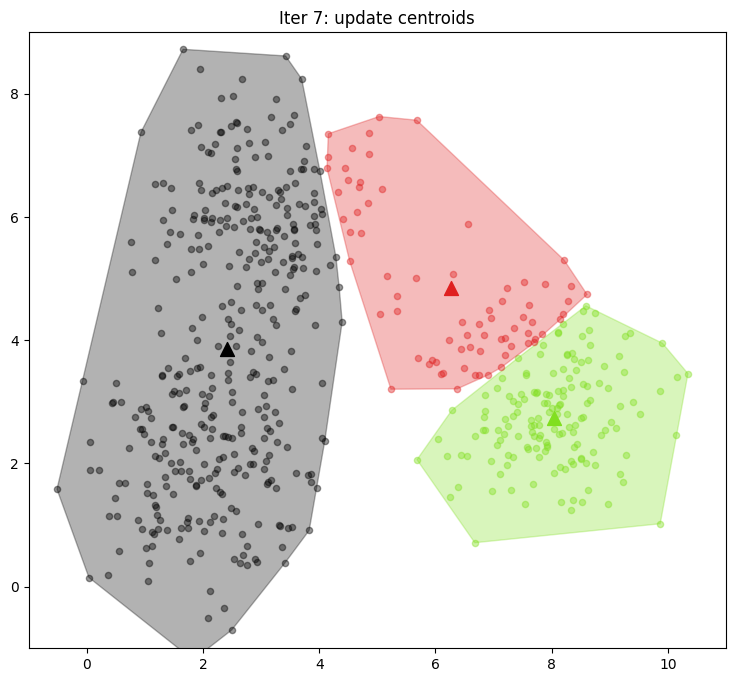

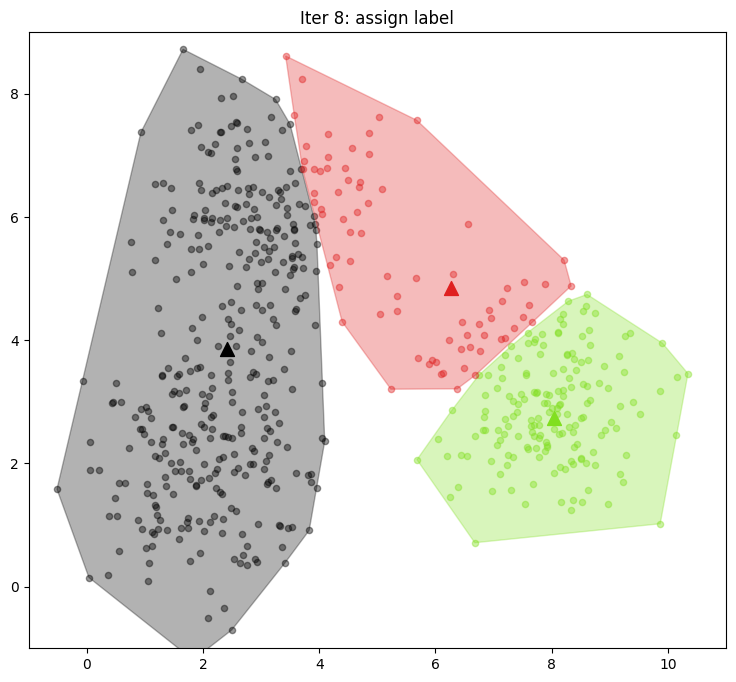

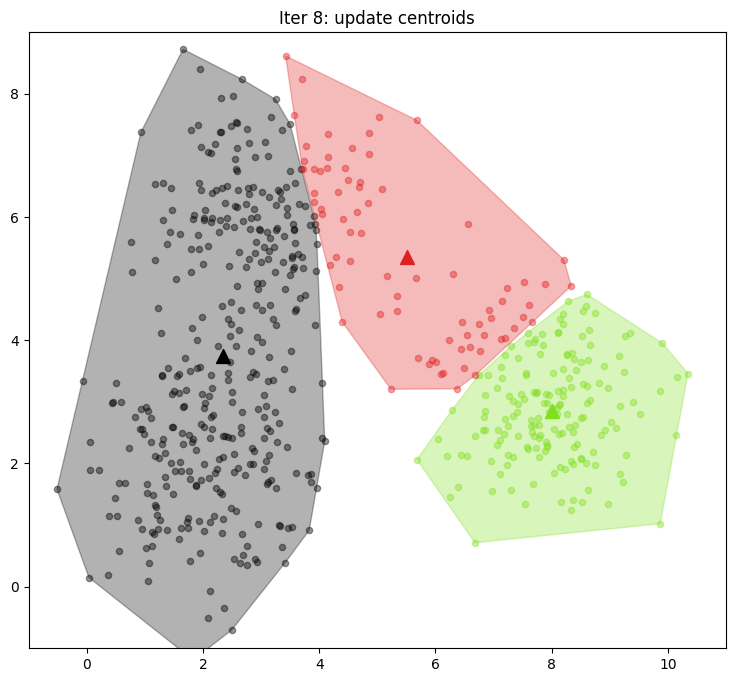

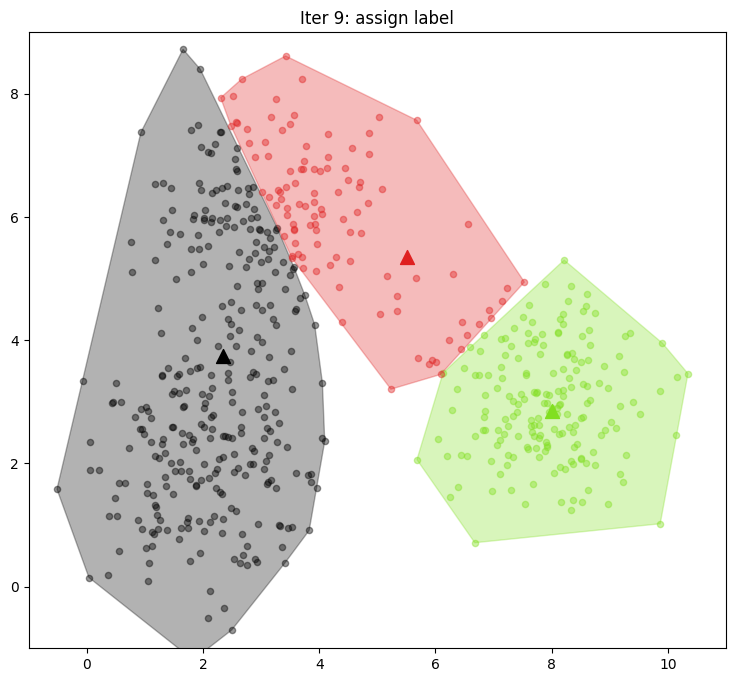

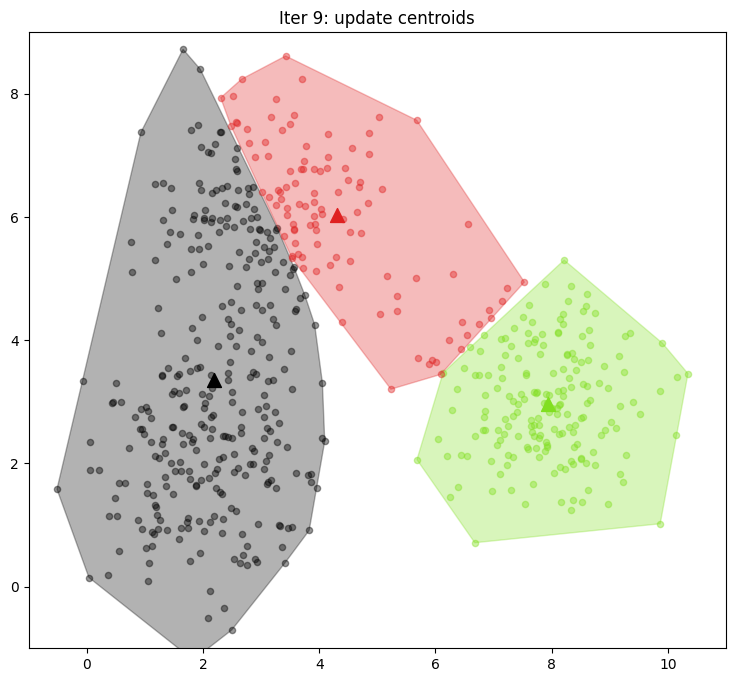

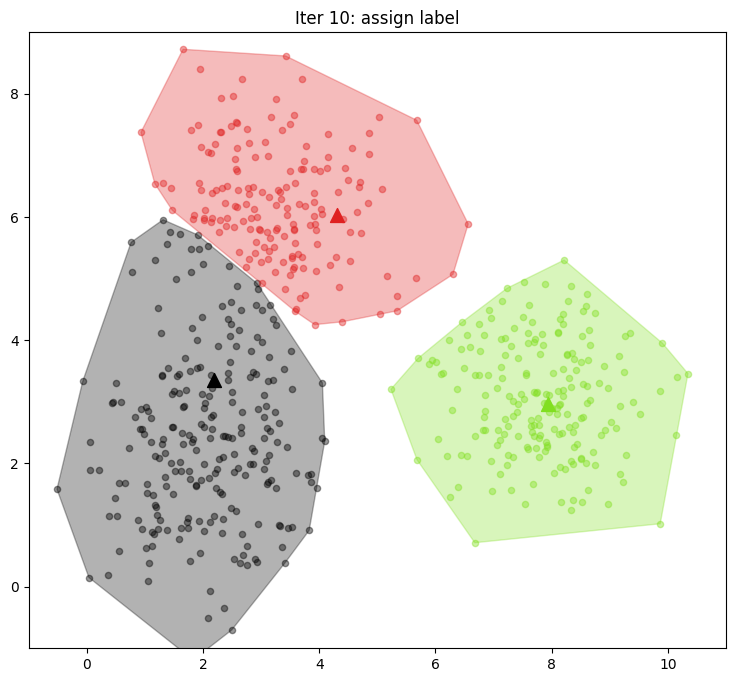

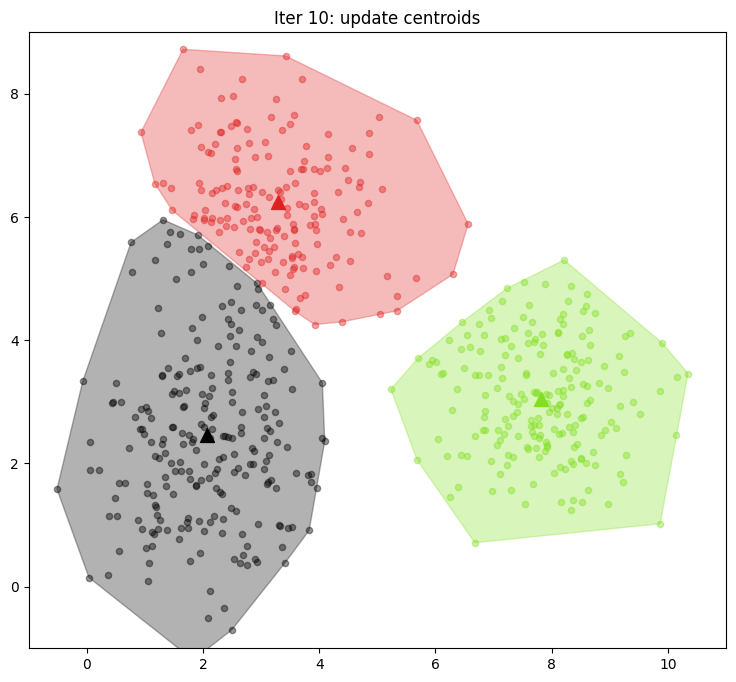

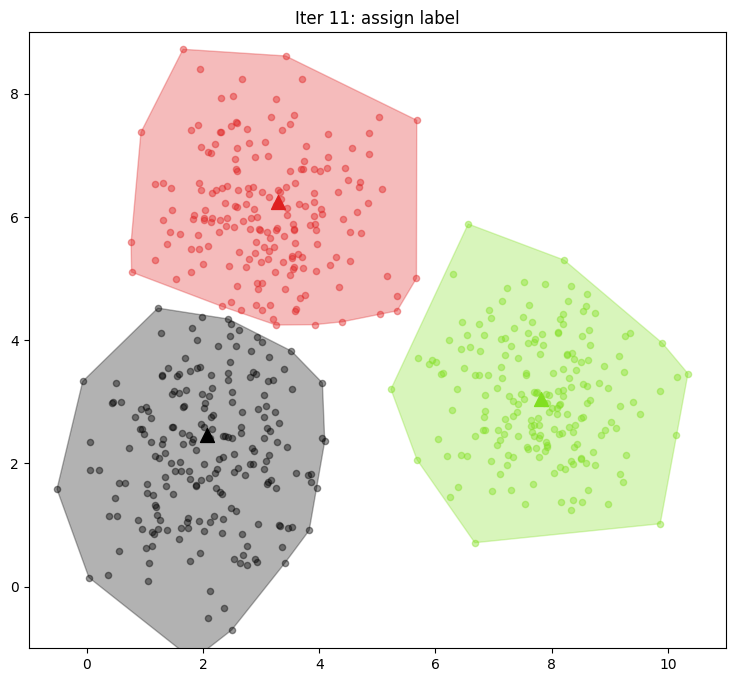

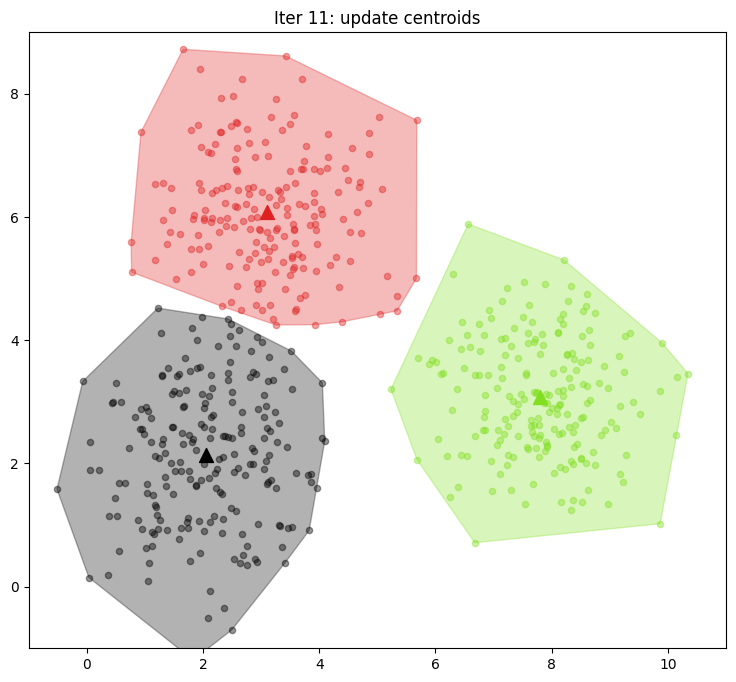

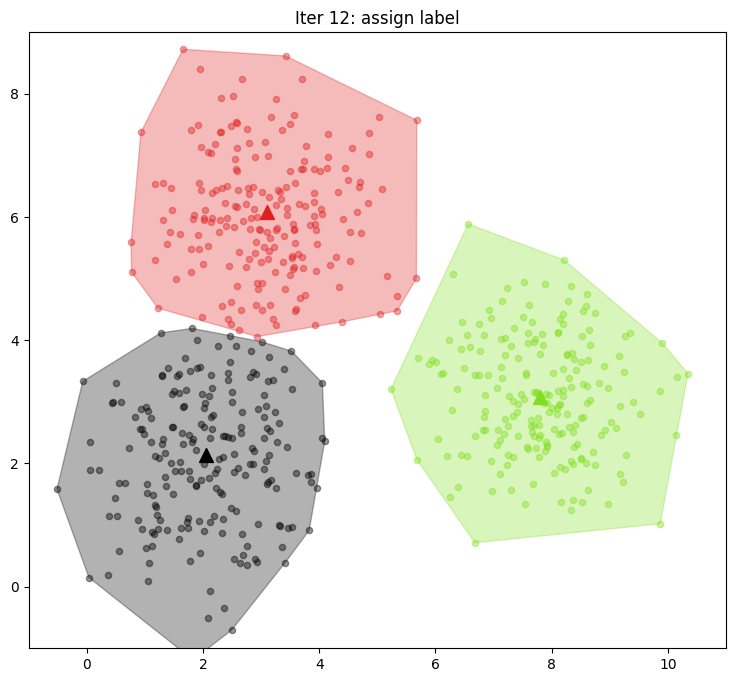

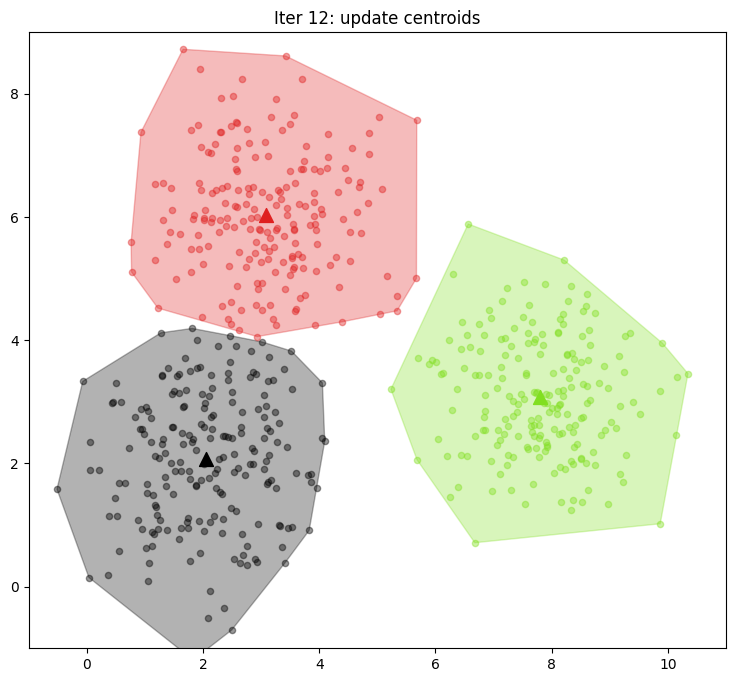

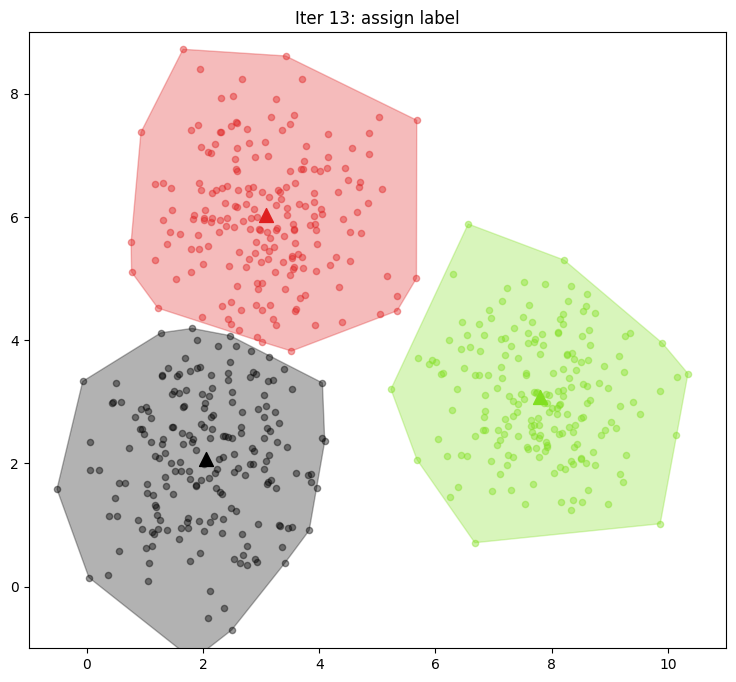

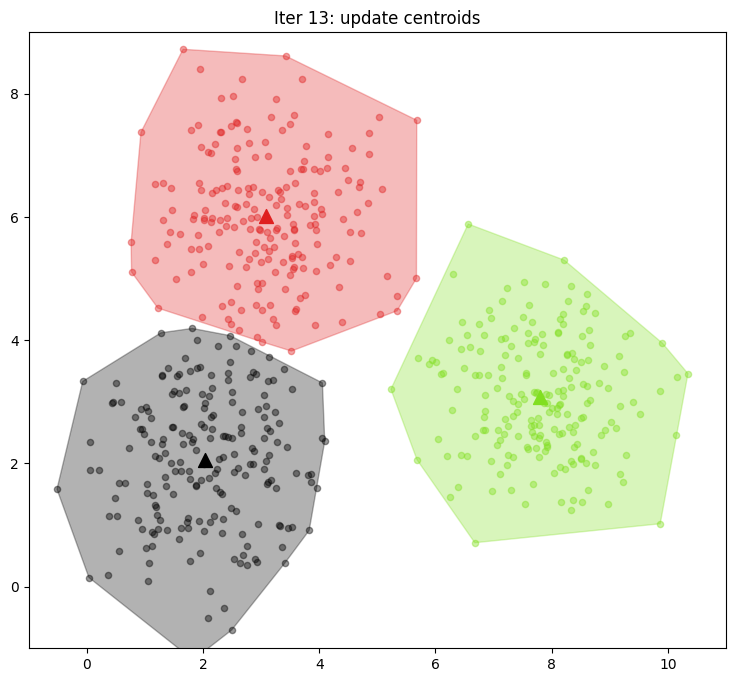

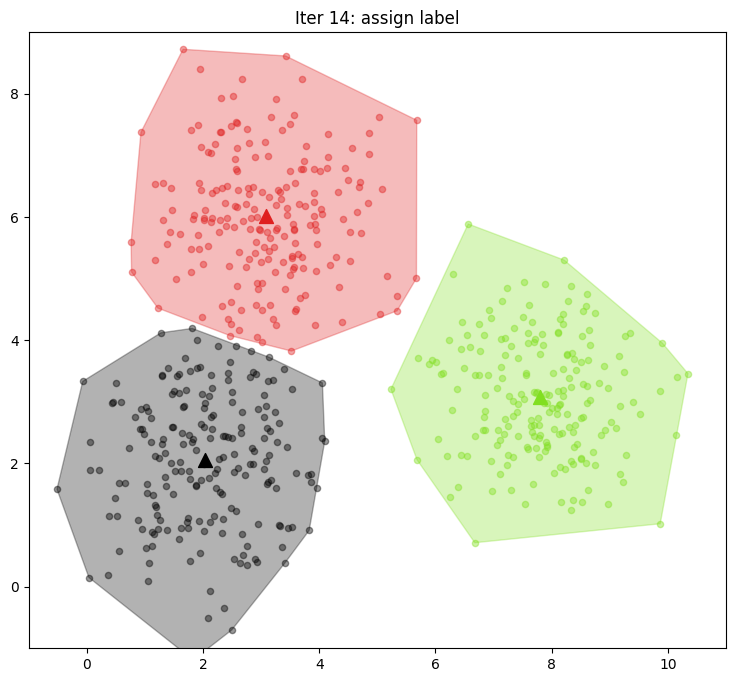

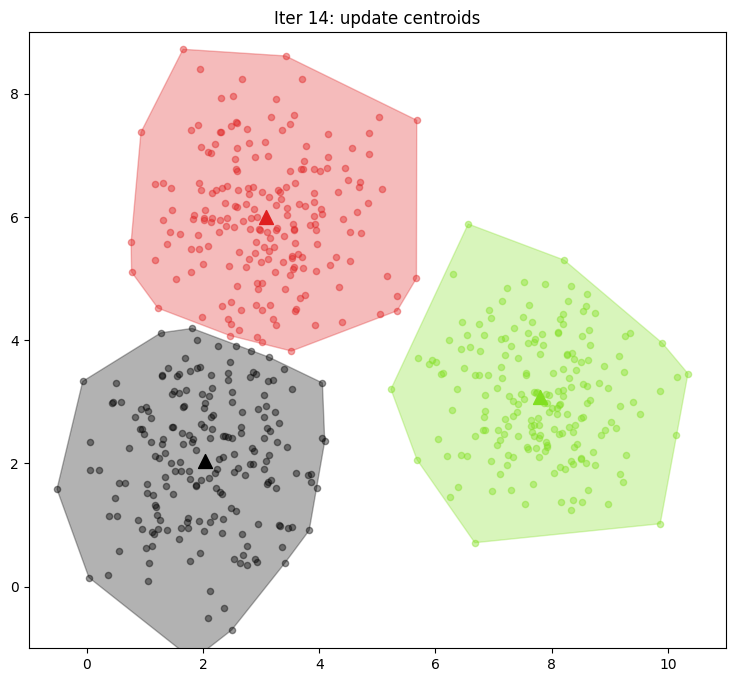

In [14]:
(n, labels, centroids) = k_means(X, 3, 30)

In [12]:
import glob
from pathlib import Path
from PIL import Image
#save GIF
frame_folder = Path('gif_image')

def getNumber(char):
    a = char.index('/')+1
    b = char.rindex('_')
    return a, b  

def sortFiles(file_dict):
    result = []
    count = 1
    while count<=len(file_dict.keys()):
        x = file_dict[count]
        x.sort(key=lambda x: x[getNumber(x)[1]+1])
        result.append(x[0])
        if len(x) > 1:
            result.append(x[1])
        count+=1
    return result
    

frames = [image for image in glob.glob(f"{frame_folder}/*.png")]
fileNames = {}
index = 0
while index<len(frames):
    frame = frames[index]
    start, end = getNumber(frame)
    num = int(frame[start:end])

    if num in fileNames.keys():
        fileNames[num].append(frame)
    else:
        fileNames[num] = [frame]

    index+=1

frames = sortFiles(fileNames)
frames = [Image.open(frame) for frame in frames]

frame_one = frames[0]
frame_one.save("demo_k-means.gif", format="GIF", append_images=frames,
            save_all=True, duration=1000, loop=0)